In [52]:
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

""" Custom modules """
sys.path.append('lib') # All custom modules are in the lib folder

from imageutil import ImageUtil
from videoutil import VideoUtil
from hogfeatures import HogFeatureUtil
from trainer import Trainer
from vehicle_detector import VehicleDetector

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
ORIENT=9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2

In [12]:
cars, notcars = ImageUtil.load_cars_notcars_images()

In [13]:
X_scaler, scaled_X, y = HogFeatureUtil.hog_classify(cars, notcars, \
            orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
svc = LinearSVC()
svc = Trainer.train(svc, scaled_X, y)

3.57 Seconds to extract HOG features...
Feature vector length: 8460
0.32 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
0.00095 Seconds to predict 10 labels with SVC


In [14]:
# Load test images
test_images = VideoUtil.images_from_video('project_video.mp4')

100%|█████████▉| 1260/1261 [00:04<00:00, 307.39it/s]


8885
((0, 400), (16, 416))


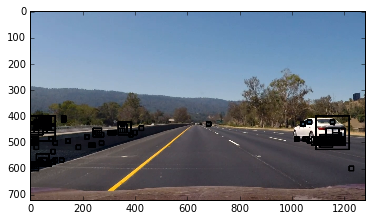

In [54]:
@interact
def testVideoImages(images=fixed(test_images), i:(0, len(test_images) - 1)=316):
    file, img = images[i]
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255    
    windows, hot_windows = VehicleDetector.search_and_classify(img, svc, X_scaler,\
                color_space='YCrCb', orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    window_img = ImageUtil.draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)  
    print(len(windows))
    print(windows[0])
    plt.imshow(window_img)    

StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)


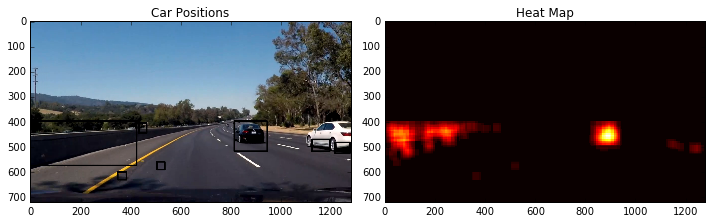

In [60]:
@interact
def test_find_cars(images=fixed(test_images), i:(0, len(test_images) - 1)=960):
    file, img = images[i]
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255   
    ystart = 400
    ystop = 656
#    scale = 1.5    
    box_list = []
    for i in range(2, 11):
        scale = i * 0.25 # scale: 0.25 ~ 2.5
        boxes, _ = VehicleDetector.find_cars(img, ystart, ystop, scale, svc, X_scaler, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
        box_list = box_list + boxes
    out_img, heatmap = VehicleDetector.apply_heat_map(img, box_list)

    fig = plt.figure(figsize=(10, 20))
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

StandardScaler(copy=True, with_mean=True, with_std=True)


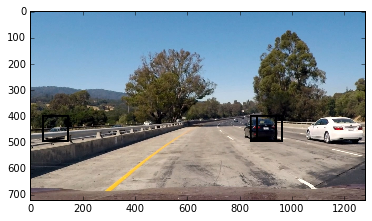

In [19]:
def test_vehicle_search():
    img = mpimg.imread('test_images/test1.jpg')
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255    
    
    ystart = 400
    ystop = 656
    scale = 1.5    
    
    _, window_img = VehicleDetector.find_cars(img, ystart, ystop, scale, svc, X_scaler, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    plt.imshow(window_img)
    
test_vehicle_search()

In [62]:
def search_and_classify(svc, X_scaler, cars, notcars):
    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time

    image = mpimg.imread('test_images/test1.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

    spatial_size = (32, 32) # Spatial binning dimensions    
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off    
    y_start_stop = [400, 720] # Min and max in y to search in slide_window()
    
    windows = VehicleDetector.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                         xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = VehicleDetector.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    print(len(windows))    
    print(len(hot_windows))    
    
    window_img = VehicleDetector.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    
#     # Add heat to each box in box list
#     heat = add_heat(heat,hot_windows)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,1)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)    
#     labels = label(heatmap)
    
#     draw_img = draw_labeled_bboxes(np.copy(image), labels)

#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
    plt.imshow(window_img)
    
search_and_classify(svc, X_scaler, cars, notcars)    

AttributeError: type object 'VehicleDetector' has no attribute 'slide_window'

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


TBD
![alt text][image3]

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]
---


